In [ ]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table align="left">
    <td>
      <a href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=BigQuery%20ML%20-%20Retail%20Demand%20Forecasting&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fanalytics-componentized-patterns%2Fraw%2Fmaster%2Fretail%2Ftime-series%2Fbqml-demand-forecasting%2Fbqml_retail_demand_forecasting.ipynb&url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fanalytics-componentized-patterns%2Ftree%2Fmaster%2Fretail%2Ftime-series%2Fbqml-demand-forecasting%2F">
        <img src="https://cloud.google.com/images/products/ai/ai-solutions-icon.svg" alt="AI Platform Notebooks">Run on AI Platform Notebooks</a>
    </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/analytics-componentized-patterns/tree/master/retail/time-series/bqml-demand-forecasting/">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
</table>

# Building a demand forecasting model by using BigQuery ML

This notebook shows you how to train, deploy, and evaluate a time series model by using BigQuery ML. It provides an end-to-end solution for forecasting multiple products. Using the public [Iowa Liquor Sales data](https://console.cloud.google.com/marketplace/details/obfuscated-ga360-data/obfuscated-ga360-data?filter=solution-type:dataset) dataset, you use a single SQL query to create five time series models, where each model forecasts the retail sales of a single liquor product. 

By the end of this notebook, you will know how to:
* Pre-process time series data into the correct format needed to create the model.
* Train the time series model in BigQuery ML.
* Evaluate the model.
* Make predictions about future demand using the model.
* Create a dashboard to visualize the forecasted demand using Data Studio.

## Setup

Install the required packages, configure the environment variables, and create a BigQuery dataset.

### PIP Install Packages and dependencies

In [1]:
!pip install google-cloud-bigquery google-cloud-bigquery-storage --upgrade

In [2]:
# Automatically restart kernel after installs
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)  

{'status': 'ok', 'restart': True}

### Configure GCP environment settings

Update the following variables to reflect the values for your GCP environment:

* PROJECT_ID: The ID of the Google Cloud project you are using to implement this solution.
* REGION: The region to use for the BigQuery dataset.

In [3]:

PROJECT_ID = 'rescue-1225' # Change to your project.
REGION = 'US'

### Import libraries and define constants

In [4]:
from google.cloud import bigquery
import pandas as pd
from datetime import datetime, timedelta

pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Import libraries for data manipulation and plotting

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_historical_and_forecast(input_timeseries, 
                                 timestamp_col_name, 
                                 data_col_name, 
                                 forecast_output=None, 
                                 actual=None, 
                                 title=None,
                                 plotstartdate=None):

    if plotstartdate:
        input_timeseries = input_timeseries[input_timeseries[timestamp_col_name] >= pd.to_datetime(plotstartdate)]
    input_timeseries = input_timeseries.sort_values(timestamp_col_name)    
    
    # Plot the input historical data
    plt.figure(figsize=(20,6))
    plt.plot(input_timeseries[timestamp_col_name], input_timeseries[data_col_name], label = 'Historical')
    plt.xlabel(timestamp_col_name)
    plt.ylabel(data_col_name)

    if forecast_output is not None:
        forecast_output = forecast_output.sort_values('forecast_timestamp')
        forecast_output['forecast_timestamp'] = pd.to_datetime(forecast_output['forecast_timestamp'])
        x_data = forecast_output['forecast_timestamp']
        y_data = forecast_output['forecast_value']
        confidence_level = forecast_output['confidence_level'].iloc[0] * 100
        low_CI = forecast_output['confidence_interval_lower_bound']
        upper_CI = forecast_output['confidence_interval_upper_bound']
        # Plot the forecast data
        plt.plot(x_data, y_data, alpha = 1, label = 'Forecast', linestyle='--')
        # Shade the confidence interval
        plt.fill_between(x_data, low_CI, upper_CI, color = '#539caf', alpha = 0.4, 
                         label = f'{confidence_level} confidence interval')

    # Plot actual data
    if actual is not None:
        actual = actual.sort_values(timestamp_col_name)
        plt.plot(actual[timestamp_col_name], actual[data_col_name], label = 'Actual', linestyle='--')   

    # Display title, legend
    plt.title(f'{title}', fontsize= 16)
    plt.legend(loc = 'upper center', prop={'size': 16})

### Create a BigQuery dataset

Create a dataset in your project called `bqmlforecast`:

In [6]:
!bq mk --location=$REGION --dataset $PROJECT_ID:bqmlforecast

Dataset 'rescue-1225:bqmlforecast' successfully created.


## Prepare the training data

You train the time series models on a dataset containing transactional data. Each row represents a transaction on a single product, as identified by the `item_description` value, and contains details such as the number of bottles sold and the sales amount in dollars. In following steps, you use the number of bottles sold value to forecast product demand.

_Note_: Jupyter runs cells starting with %%bigquery as SQL queries

In [7]:
%%bigquery --project $PROJECT_ID

SELECT 
    invoice_and_item_number,
    date,
    store_number,
    item_description,
    bottles_sold,
    sale_dollars
FROM
  `bigquery-public-data.iowa_liquor_sales.sales` 
LIMIT 
  5

Downloading: 100%|██████████| 5/5 [00:01<00:00,  3.47rows/s]


,invoice_and_item_number,date,store_number,item_description,bottles_sold,sale_dollars
0,INV-33342800023,2021-01-11,4306,Dekuyper Triple Sec,4,14.000
1,INV-33294200002,2021-01-08,4678,Midnight Moon Apple Pie,18,310.500
2,INV-18558500017,2019-04-04,5098,Bacardi Gold Mini,4,33.240
3,S09542200174,2012-12-18,2629,Jameson,4,104.400
4,S19099700002,2014-05-23,3713,Captain Morgan Original Spiced 1.75L w/CM Whit...,78,2077.140


### [Optional] Transform your data to the expected schema

If you use the sample dataset, you can skip this step.

If you want to use your own data, import your sales data to BigQuery, and then adapt the following SQL query to create a view with the appropriate schema. Update `[YOUR_PROJECT].[YOUR_DATASET].[YOUR_SOURCE_TABLE]` to reflect the project, dataset, and table containing your sales data.

In [ ]:
# %%bigquery --project $PROJECT_ID

# CREATE OR REPLACE VIEW bqmlforecast.training_data AS (
# SELECT
#   date,
#   item_name,
#   total_amount_sold
# FROM
#   `bigquery-public-data.iowa_liquor_sales.sales` 
# );

### Set the start and end dates for the training data

You can adjust the `TRAININGDATA_STARTDATE` and `TRAININGDATA_ENDDATE` parameters to specify the start/end dates of your training data:

In [10]:
ARIMA_PARAMS = {
    'TRAININGDATA_STARTDATE': '2019-01-01',
    'TRAININGDATA_ENDDATE': '2020-03-01',
}
ARIMA_PARAMS

{'TRAININGDATA_STARTDATE': '2019-01-01', 'TRAININGDATA_ENDDATE': '2020-03-01'}

### Write the training data to a table

## Cluster -Try 1

In [32]:
%%bigquery --params $ARIMA_PARAMS  --project $PROJECT_ID 
CREATE OR REPLACE MODEL bqmlforecast.model
OPTIONS(model_type='kmeans', num_clusters=4, standardize_features = false) AS 
   WITH  stores AS
    (
        SELECT   
        ST_DISTANCE( ST_GEOGFROMTEXT(store_location), ST_GEOGPOINT(-96.358955 , 42.473503 )) as distance_nw,
        ST_DISTANCE( ST_GEOGFROMTEXT(store_location), ST_GEOGPOINT(-91.785706 , 43.303307 )) as distance_ne,
        ST_DISTANCE( ST_GEOGFROMTEXT(store_location), ST_GEOGPOINT(-95.376151 , 40.766739 )) as distance_sw,
        ST_DISTANCE( ST_GEOGFROMTEXT(store_location), ST_GEOGPOINT(-90.590836 , 41.543056 )) as distance_se
        
    FROM
        `bigquery-public-data.iowa_liquor_sales.sales` 
    WHERE
         date BETWEEN @TRAININGDATA_STARTDATE AND @TRAININGDATA_ENDDATE  
    GROUP BY store_location
    
    
)

SELECT * from stores
    




Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 1783.80query/s]                        


""


In [33]:
%%bigquery --params $ARIMA_PARAMS  --project $PROJECT_ID 

SELECT davies_bouldin_index 
FROM ML.EVALUATE(MODEL bqmlforecast.model)

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.51s/rows]


,davies_bouldin_index
0,1.142


In [76]:
%%bigquery --params $ARIMA_PARAMS  --project $PROJECT_ID 

   
         SELECT store_name, city,ST_DISTANCE( ST_GEOGFROMTEXT(store_location), ST_GEOGPOINT(-93.598022, 41.619549 )) as distance   
    from `bigquery-public-data.iowa_liquor_sales.sales`
    )
   

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 1184.50query/s] 


""


In [50]:
# %%bigquery --params $ARIMA_PARAMS  --project $PROJECT_ID 

#  CREATE OR REPLACE VIEW bqmlforecast.iowa_distances AS
# (SELECT   store_name ,
#         store_number,
#          zip_code,
#         sale_dollars, bottles_sold , volume_sold_liters,
#         item_description, category, category_name, state_bottle_retail,
#         state_bottle_cost, ST_GEOGFROMTEXT(store_location) as location , 
#          county, city, address, vendor_number, vendor_name,
#         ST_DISTANCE( ST_GEOGFROMTEXT(store_location), ST_GEOGPOINT(-96.358955 , 42.473503 )) as distance_nw,
#         ST_DISTANCE( ST_GEOGFROMTEXT(store_location), ST_GEOGPOINT(-91.785706 , 43.303307 )) as distance_ne,
#         ST_DISTANCE( ST_GEOGFROMTEXT(store_location), ST_GEOGPOINT(-95.376151 , 40.766739 )) as distance_sw,
#         ST_DISTANCE( ST_GEOGFROMTEXT(store_location), ST_GEOGPOINT(-90.590836 , 41.543056 )) as distance_se
        
   
        
#     FROM
#         `bigquery-public-data.iowa_liquor_sales.sales` 
#     WHERE
#          date BETWEEN '2019-01-01' AND '2020-01-01'
 
    
     
     
# )
    

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 786.78query/s]  


""


## Run from here 

In [11]:
%%bigquery --params $ARIMA_PARAMS  --project $PROJECT_ID 

 CREATE OR REPLACE VIEW bqmlforecast.iowa_store_dist AS
(SELECT 
        distinct store_number,
        ST_DISTANCE( ST_GEOGFROMTEXT(store_location), ST_GEOGPOINT(-96.358955 , 42.473503 )) as distance_nw,
        ST_DISTANCE( ST_GEOGFROMTEXT(store_location), ST_GEOGPOINT(-91.785706 , 43.303307 )) as distance_ne,
        ST_DISTANCE( ST_GEOGFROMTEXT(store_location), ST_GEOGPOINT(-95.376151 , 40.766739 )) as distance_sw,
        ST_DISTANCE( ST_GEOGFROMTEXT(store_location), ST_GEOGPOINT(-90.590836 , 41.543056 )) as distance_se
        
   
        
    FROM
        `bigquery-public-data.iowa_liquor_sales.sales` 
    WHERE
         date BETWEEN '2019-01-01' AND '2020-01-01' AND
         store_location IS NOT NULL
         

     
 
    
     
     
)
    

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 664.50query/s]  


""


In [25]:
%%bigquery --params $ARIMA_PARAMS  --project $PROJECT_ID 

 CREATE OR REPLACE VIEW bqmlforecast.iowa_store_stats AS
(SELECT 
        store_number,
        SUM(sale_dollars) as Total_Sale_Dollars,
        SUM(bottles_sold) as Total_bottles_sold,
        SUM(volume_sold_liters) as Total_volume_sold_liters,
        COUNT(item_description) as Count_transactions,
        AVG(state_bottle_cost) as AVG_bottle_cost,
        AVG(state_bottle_retail) as AVG_bottle_retail,
            
    FROM
        `bigquery-public-data.iowa_liquor_sales.sales` 
    WHERE
         date BETWEEN '2019-01-01' AND '2020-01-01' AND
         store_location IS NOT NULL
         
    GROUP BY store_number
     
 
    
     
     
)

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 652.51query/s]  


""


In [13]:
%%bigquery --params $ARIMA_PARAMS  --project $PROJECT_ID 

 CREATE OR REPLACE VIEW bqmlforecast.iowa_clusters AS
(SELECT store_number, distance_nw, distance_ne, distance_sw, distance_se,
     CASE WHEN distance_nw< distance_ne AND distance_nw < distance_sw AND distance_nw < distance_se THEN '1'
         WHEN distance_ne < distance_nw AND distance_ne < distance_sw AND distance_ne < distance_se THEN '2'
         WHEN distance_sw < distance_nw AND distance_sw <distance_ne AND distance_sw < distance_se THEN '3'
         WHEN distance_se < distance_nw AND distance_se <distance_ne AND distance_se < distance_sw THEN '4'
         ELSE '0'
         END
         AS Cluster
 FROM bqmlforecast.iowa_store_dist )

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 907.86query/s]  


""


In [22]:
%%bigquery --params $ARIMA_PARAMS  --project $PROJECT_ID 

 CREATE OR REPLACE VIEW bqmlforecast.iowa_store_data AS
    (
        SELECT  distinct a.store_number, a.Cluster ,c.store_location, UPPER(c.address) AS address ,UPPER(c.city) as city, c.zip_code , 
        b.Total_Sale_Dollars , b.Total_bottles_sold , b.Total_volume_sold_liters, b.Count_transactions, b.AVG_bottle_cost, b.AVG_bottle_retail
        FROM  bqmlforecast.iowa_clusters a, bqmlforecast.iowa_store_stats b,  `bigquery-public-data.iowa_liquor_sales.sales` c
        WHERE a.store_number = b.store_number AND a.store_number = c.store_number
    )

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 983.42query/s]  


""


In [23]:
%%bigquery --params $ARIMA_PARAMS  --project $PROJECT_ID 

SELECT * from bqmlforecast.iowa_store_data
WHERE Cluster = '1'
ORDER BY store_number

Downloading: 100%|██████████| 292/292 [00:01<00:00, 198.32rows/s]


,store_number,Cluster,store_location,address,city,zip_code,Total_Sale_Dollars,Total_bottles_sold,Total_volume_sold_liters,Count_transactions,AVG_bottle_cost,AVG_bottle_retail
0,2113,1,POINT (-94.289457 42.28057),1119 MARKET ST. BOX 71,GOWRIE,50543,78947.790,6052,5593.060,1613,10.854,16.284
1,2200,1,POINT (-94.974011 42.421341),619 E MAIN ST,SAC CITY,50583,244140.880,16020,17447.510,4098,12.385,18.580
2,2233,1,POINT (-95.126786 43.416433),2508 ENTERPRISE AVE,SPIRIT LAKE,51360,274552.160,18155,18481.850,2016,13.797,20.811
3,2475,1,POINT (-94.443 42.96298),206 2ND AVE NE,WEST BEND,50597,39981.550,2538,3412.690,316,11.617,17.428
4,2556,1,None,2608 E. CENTRAL AVENUE,ESTHERVILLE,51334,501595.450,33087,34952.280,4731,10.452,15.680
...,...,...,...,...,...,...,...,...,...,...,...,...
287,5876,1,POINT (-73.982421 40.305231000000006),108 S BROADWAY,WEST BEND,50597,35002.380,2484,2311.500,215,10.176,15.267
288,5880,1,POINT (-95.624301 43.085223),215 S RERICK AVE,PRIMGHAR,51245,2394.970,261,169.810,34,8.565,12.849
289,9023,1,POINT (-94.874691 42.056362),"314, PRAIRIE VIEW DR.",CARROLL,51401,2250.000,42,31.500,4,37.500,56.250
290,9031,1,POINT (-95.479709 41.770879),1833 ELMWOOD RD,EARLING,51530,39690.000,1296,972.000,26,17.654,26.481


In [81]:
%%bigquery --params $ARIMA_PARAMS  --project $PROJECT_ID 

CREATE OR REPLACE VIEW bqmlforecast.iowa_liquor_sales_forecasting AS
    (
        SELECT   a.Cluster , 
        SUM(c.sale_dollars) AS total_sale_dollars, c.date , SUM( c.bottles_sold) AS total_bottles_sold , SUM( c.volume_sold_liters) as total_volume_sold_liters
        FROM  bqmlforecast.iowa_clusters a,  `bigquery-public-data.iowa_liquor_sales.sales` c
        WHERE store_location IS NOT NULL AND 
        date BETWEEN '2019-01-01' AND '2020-11-01'
        AND  a.store_number = c.store_number
        GROUP BY cluster,date
        
    )


Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 401.18query/s] 


""


In [82]:
%%bigquery --params $ARIMA_PARAMS  --project $PROJECT_ID 

SELECT * from bqmlforecast.iowa_liquor_sales_forecasting
WHERE cluster = '1'


Query is running:   0%|          | 0/1 [00:00<?, ?query/s]
Query executing stage S00: Input and status COMPLETE : 0.00s:   0%|          | 0/5 [00:00<?, ?query/s]
Query complete after 0.01s: 100%|██████████| 5/5 [00:00<00:00, 1016.26query/s]                        

Downloading: 100%|██████████| 438/438 [00:01<00:00, 305.10rows/s]


,Cluster,total_sale_dollars,date,total_bottles_sold,total_volume_sold_liters
0,1,111301.950,2019-04-22,8250,7787.840
1,1,428693.610,2020-04-28,30896,26429.990
2,1,155816.750,2020-09-30,11484,10407.440
3,1,332155.680,2020-10-06,27618,21295.070
4,1,319869.750,2019-10-01,25082,19258.790
...,...,...,...,...,...
433,1,7.500,2019-06-06,1,0.500
434,1,15.600,2020-02-27,1,0.750
435,1,94.080,2019-06-20,6,10.500
436,1,115.500,2020-02-13,11,8.250


### Plot the sales histories of the target liquor products

Save the training data to the `dfhistorical` Pandas dataframe:

In [83]:
%%bigquery dfhistorical --project $PROJECT_ID 

SELECT 
    * 
FROM 
   bqmlforecast.iowa_liquor_sales_forecasting
ORDER BY Cluster


Query is running:   0%|          | 0/1 [00:00<?, ?query/s]
Query executing stage S00: Input and status COMPLETE : 0.00s:   0%|          | 0/6 [00:00<?, ?query/s]
Query complete after 0.01s: 100%|██████████| 6/6 [00:00<00:00, 1111.91query/s]                        

Downloading: 100%|██████████| 1868/1868 [00:01<00:00, 1073.08rows/s]A


Using the training data, plot the sales histories of the target liquor products:

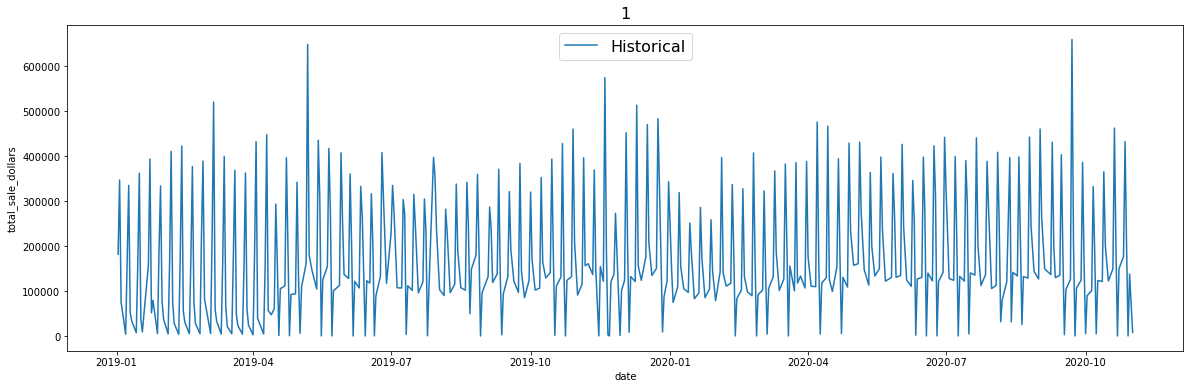

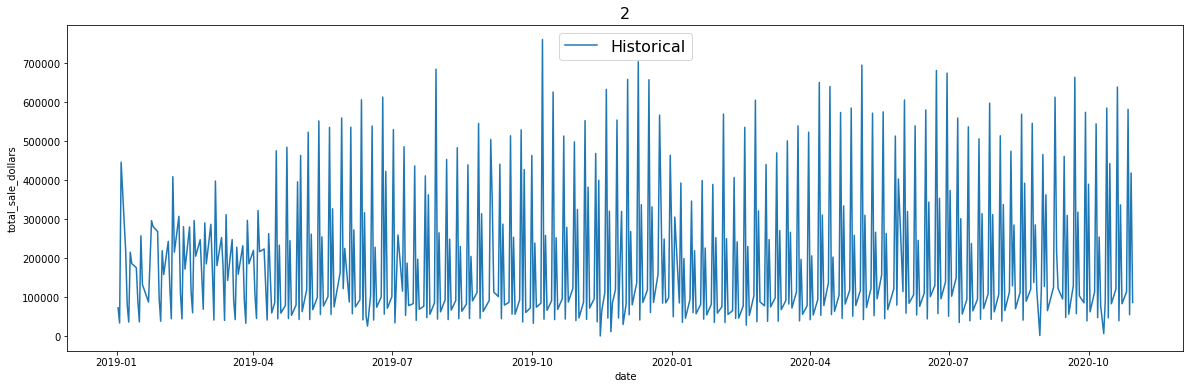

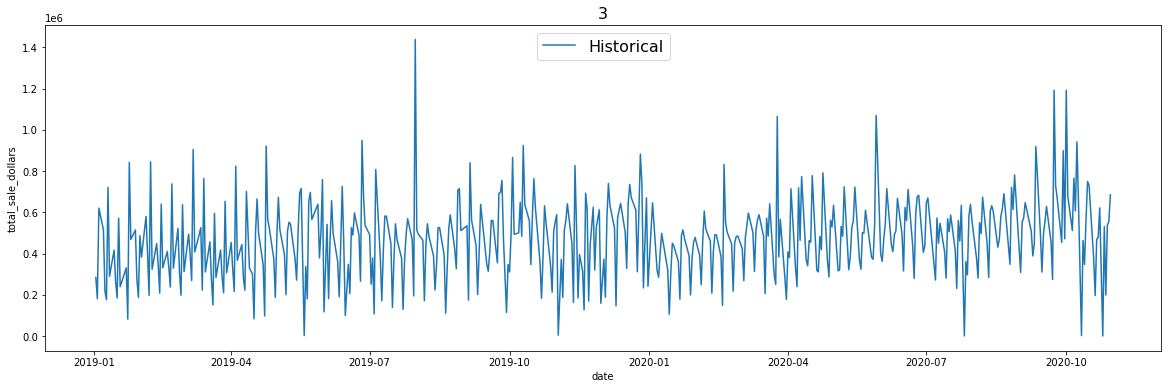

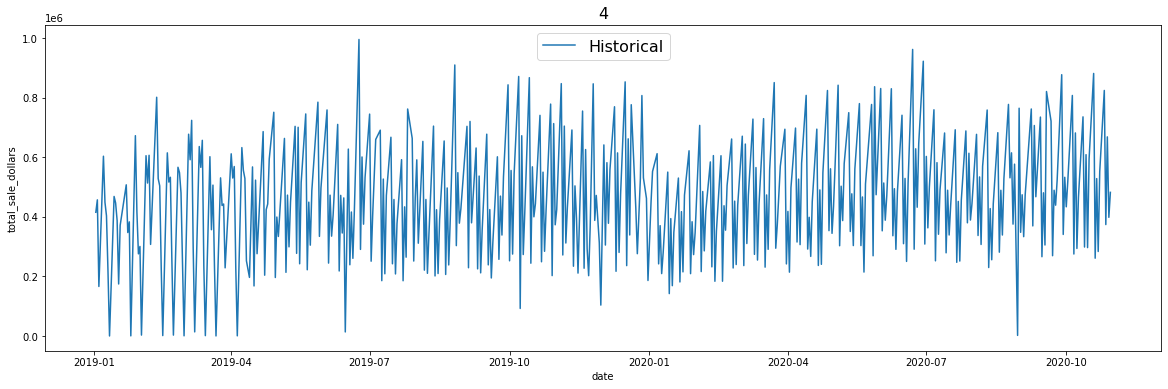

In [84]:
clusterlist = list(dfhistorical.Cluster.unique())

for cluster in clusterlist:
    
    datah = dfhistorical[dfhistorical.Cluster==cluster]
    plot_historical_and_forecast(input_timeseries = datah, 
                                 timestamp_col_name = "date", 
                                 data_col_name = "total_sale_dollars", 
                                 forecast_output = None, 
                                 actual = None,
                                 title = cluster)

## Train the model

Because you are training the model on multiple products in a single model creation statement, you must specify the `item_name` column for the [TIME_SERIES_ID_COL](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-time-series#time_series_id_col) parameter. If you were only forecasting a single item, then you would not need to specify `TIME_SERIES_ID_COL`. For more information, see the [BigQuery ML time series model creation documentation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-time-series#create_model_syntax).

You can also account for holiday effects when doing time series modeling in BigQuery ML. By default, holiday effects modeling is disabled. But since this data is from the United States, and the data includes a minimum one year of daily data, you can also specify an optional `HOLIDAY_REGION`. With holiday effects enabled, spikes and dips that appear during holidays will no longer be treated as anomalies. A full list of the holiday regions can be found in the [HOLIDAY_REGION documentation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-time-series#holiday_region).



In [86]:
%%bigquery --project $PROJECT_ID 

CREATE OR REPLACE MODEL bqmlforecast.arima_model

OPTIONS(
  MODEL_TYPE='ARIMA',
  TIME_SERIES_TIMESTAMP_COL='date', 
  TIME_SERIES_DATA_COL='total_sale_dollars',
  TIME_SERIES_ID_COL='Cluster',
  HOLIDAY_REGION='US'
) AS

SELECT 
    date,
    Cluster,
    total_sale_dollars
FROM
 bqmlforecast.iowa_liquor_sales_forecasting
WHERE date BETWEEN '2019-01-01' AND '2020-01-01'


Query is running:   0%|          | 0/1 [00:00<?, ?query/s]
Query executing stage Preprocess and status COMPLETE : 0.00s:   0%|          | 0/3 [00:00<?, ?query/s]
Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 694.84query/s]                         


""


### Evaluate the model

Use the [ML.EVALUATE](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate) function to see the evaluation metrics of all the created models. 

The `non_seasonal_`{`p`,`d`,`q`} and `has_drift` columns define the time series model. The `log_likelihood`, `AIC`, and `variance` columns are relevant to the model fitting process. The fitting process determines the best model by using the [auto.ARIMA algorithm](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-time-series#auto_arima), one for each time series.

In [87]:
%%bigquery --project $PROJECT_ID 

SELECT
  *
FROM
  ML.EVALUATE(MODEL bqmlforecast.arima_model)


Query is running:   0%|          | 0/1 [00:00<?, ?query/s]
Query executing stage S00: Input and status COMPLETE : 0.00s:   0%|          | 0/2 [00:00<?, ?query/s]
Query complete after 0.01s: 100%|██████████| 2/2 [00:00<00:00, 431.27query/s]                         

Downloading: 100%|██████████| 4/4 [00:01<00:00,  2.73rows/s]


,Cluster,non_seasonal_p,non_seasonal_d,non_seasonal_q,has_drift,log_likelihood,AIC,variance,seasonal_periods
0,1,0,1,5,False,-4435.533,8883.066,2350258457.787,[WEEKLY]
1,2,2,1,3,True,-4558.780,9131.561,4574249521.461,[WEEKLY]
2,3,0,1,5,True,-4676.081,9366.161,8703617881.997,[WEEKLY]
3,4,0,1,5,False,-4655.678,9323.355,7842232725.457,[WEEKLY]


You can see that five models were trained, one for each of the products in the `item_name` column. Each model has its own `p,d,q` hyperparameters, and the detected seasonality for these five models is `WEEKLY`.

## Make predictions using the model

Make predictions using [ML.FORECAST](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-forecast), which forecasts the next _n_ values, as specified in the `horizon` parameter. You can also optionally change the `confidence_level` parameter to change the percentage of future values that fall in the prediction interval. You save the prediction data to the `dfforecast` dataframe so that you can plot it in a following step.


In [88]:
%%bigquery dfforecast --project $PROJECT_ID 

DECLARE HORIZON STRING DEFAULT "180"; #number of values to forecast
DECLARE CONFIDENCE_LEVEL STRING DEFAULT "0.90";

EXECUTE IMMEDIATE format("""
    SELECT
      *
    FROM 
      ML.FORECAST(MODEL bqmlforecast.arima_model, 
                  STRUCT(%s AS horizon, 
                         %s AS confidence_level)
                 )
    """,HORIZON,CONFIDENCE_LEVEL)


Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 464.07query/s] 

Downloading: 100%|██████████| 720/720 [00:01<00:00, 493.76rows/s]


In [89]:
dfforecast.head()

,Cluster,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,confidence_interval_lower_bound,confidence_interval_upper_bound
0,1,2020-01-01 00:00:00+00:00,144443.575,48482.499,0.900,64783.377,224103.772,64783.377,224103.772
1,1,2020-01-02 00:00:00+00:00,53643.020,51232.922,0.900,-30536.318,137822.357,-30536.318,137822.357
2,1,2020-01-03 00:00:00+00:00,106696.479,51562.986,0.900,21974.824,191418.135,21974.824,191418.135
3,1,2020-01-04 00:00:00+00:00,151815.865,59140.739,0.900,54643.422,248988.308,54643.422,248988.308
4,1,2020-01-05 00:00:00+00:00,125770.441,71029.751,0.900,9063.505,242477.378,9063.505,242477.378


Since `horizon` is set to 30, the result is 30 x (number of items), with one row per forecasted value:

In [90]:
print(f"Number of rows: {dfforecast.shape[0]}")

Number of rows: 720


#### Inspect the model coefficients

You can view the coefficients of each of the time series models using [ML.ARIMA_COEFFICIENTS](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-arima-coefficients).

For each of the models, the `ar_coefficients` value shows the model coefficients of the autoregressive (AR) part of the time series model. Similarly, the `ma_coefficients` value shows the model coefficients of the moving-average (MA) part of the model. Both of these values are arrays, and their lengths are equal to `non_seasonal_p` and `non_seasonal_q`, respectively. The `intercept_or_drift` value is the constant term in the time series model.

In [91]:
%%bigquery --project $PROJECT_ID 

SELECT
  *
FROM 
  ML.ARIMA_COEFFICIENTS(MODEL bqmlforecast.arima_model)


Query is running:   0%|          | 0/1 [00:00<?, ?query/s]
Query executing stage S00: Input and status COMPLETE : 0.00s:   0%|          | 0/2 [00:00<?, ?query/s]
Query complete after 0.01s: 100%|██████████| 2/2 [00:00<00:00, 206.11query/s]                         

Downloading: 100%|██████████| 4/4 [00:01<00:00,  3.20rows/s]


,Cluster,ar_coefficients,ma_coefficients,intercept_or_drift
0,1,[],"[-0.6584953114060191, -0.46166046660448706, 0....",0.000
1,2,"[-0.5115947996204446, -0.7036290302593554]","[-0.5272808303123657, 0.5272803714178215, -0.9...",-118.653
2,3,[],"[-0.7952706837959104, -0.3248549470619194, 0.7...",300.020
3,4,[],"[-0.5276586959228244, 0.24361148417988718, -0....",0.000


#### Plot the forecasted predictions against the historical data

Plot the forecasted predictions, using the `dfhistorical` dataframe that contains the historical data that you used for training and the `dfforecast` dataframe that contains the prediction data:

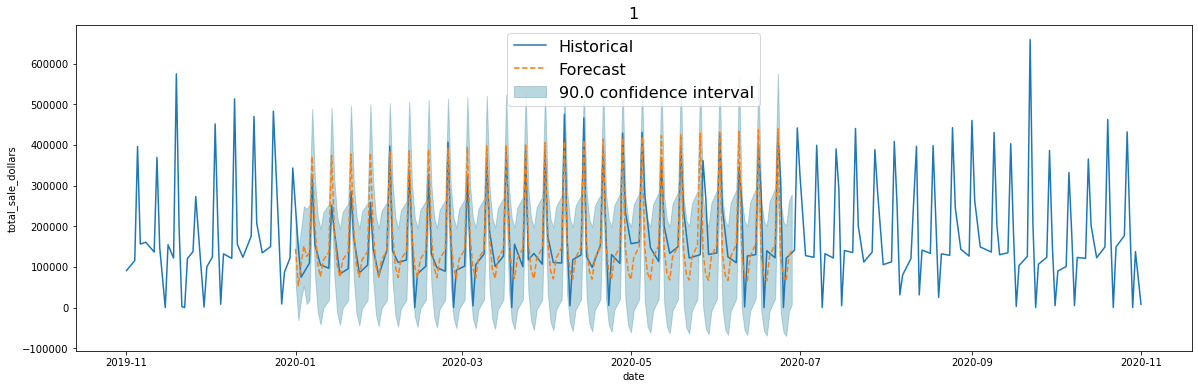

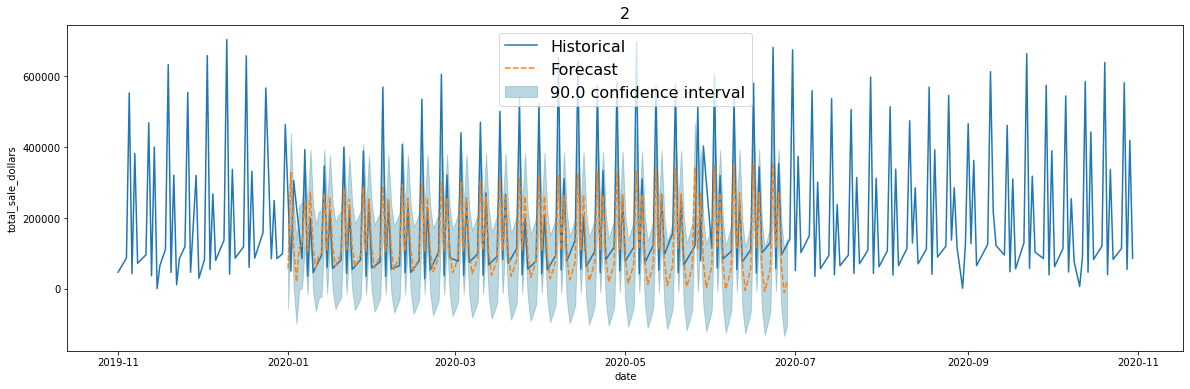

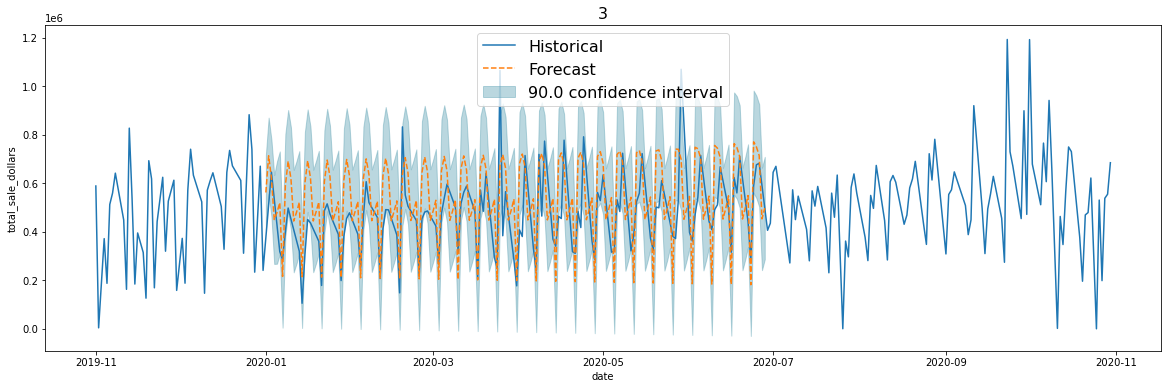

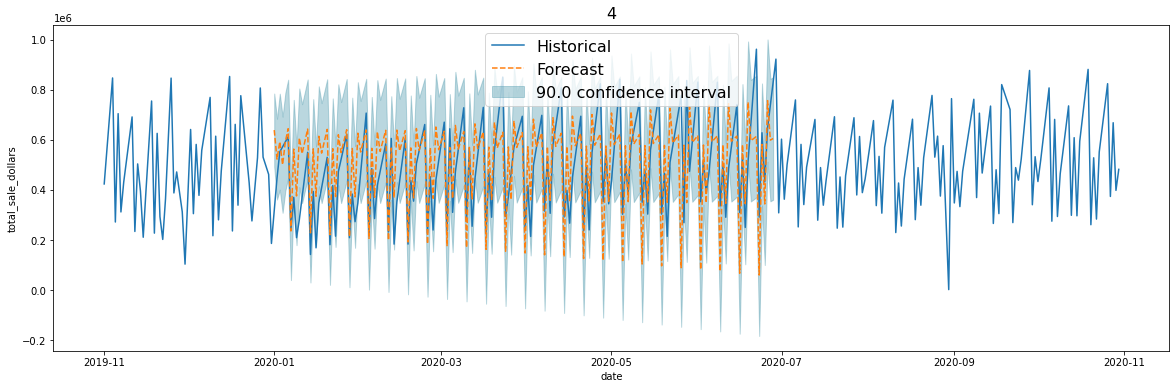

In [93]:
clusterlist = list(dfhistorical.Cluster.unique())

for cluster in clusterlist:
    datah = dfhistorical[dfhistorical.Cluster==cluster]
    dataf = dfforecast[dfforecast.Cluster==cluster]
    
    plot_historical_and_forecast(input_timeseries = datah, 
                                 timestamp_col_name = "date", 
                                 data_col_name = "total_sale_dollars", 
                                 forecast_output = dataf, 
                                 actual = None,
                                 title = cluster,
                                 plotstartdate = "2019-11-01")

#### Plot the forecasted predictions against the actual data

Save the actual sales data to the `dfactual` Pandas dataframe:

In [100]:
%%bigquery dfactual --params $ARIMA_PARAMS --project $PROJECT_ID 

DECLARE HORIZON STRING DEFAULT "180"; #number of values to forecast

SELECT 
    date,
    Cluster,
    SUM(total_sale_dollars) AS total_sale_dollars
FROM
      bqmlforecast.iowa_liquor_sales_forecasting
GROUP BY
    Cluster, date
HAVING 
    date BETWEEN DATE_ADD(@TRAININGDATA_ENDDATE, 
                              INTERVAL 1 DAY) 
            AND DATE_ADD(@TRAININGDATA_ENDDATE, 
                             INTERVAL 1+CAST(HORIZON AS INT64) DAY) 
ORDER BY
    date;

Downloading: 100%|██████████| 504/504 [00:01<00:00, 353.32rows/s]


In [101]:
dfactual.head()

,date,Cluster,total_sale_dollars
0,2020-03-02,4,670653.230
1,2020-03-02,2,78057.830
2,2020-03-02,3,423982.040
3,2020-03-02,1,101982.320
4,2020-03-03,1,322592.210


Plot the forecasted predictions against the training data and actual values, using the `dfhistorical` dataframe that contains the historical data, the `dfforecast` dataframe that contains the prediction data, and the `dfactual` dataframe that contains the actual sales data:

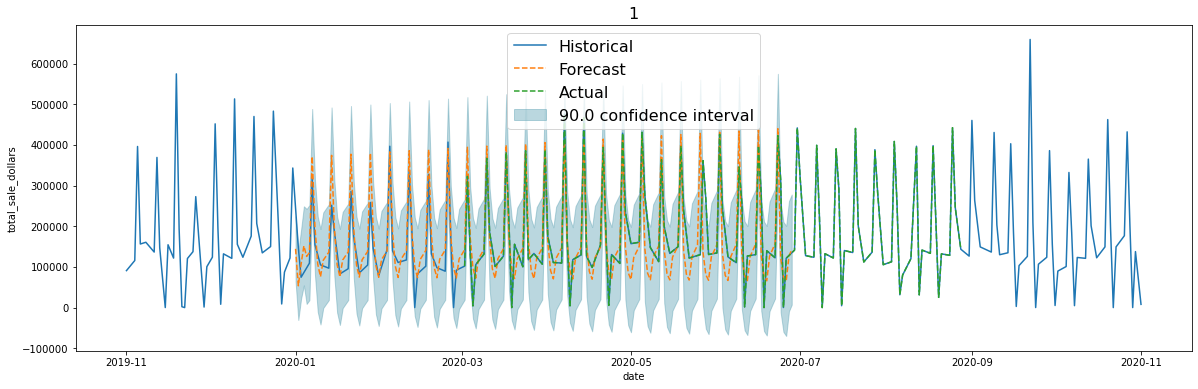

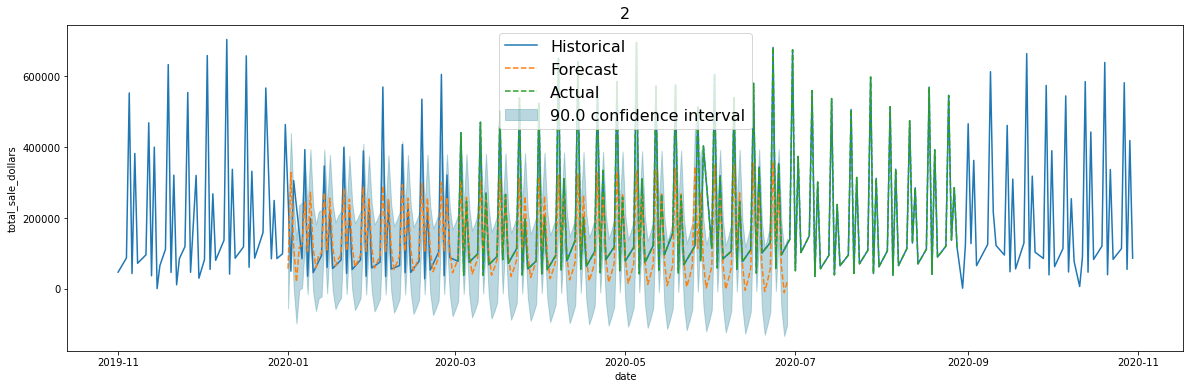

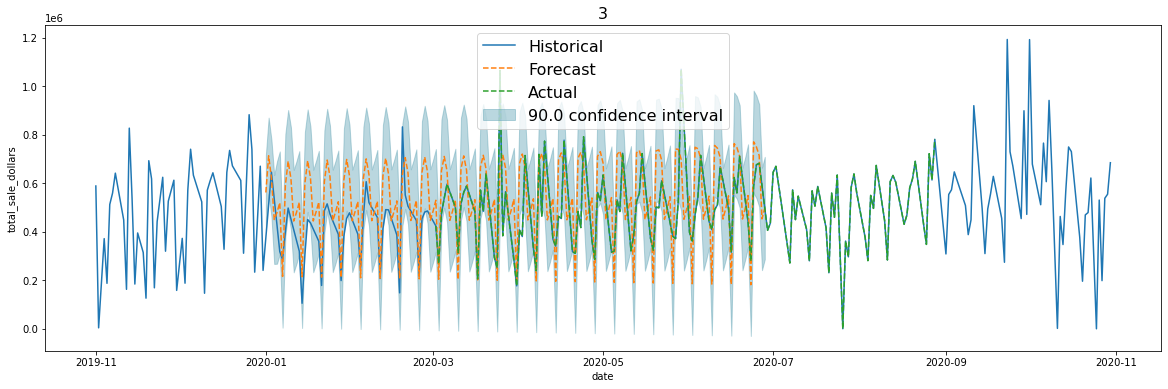

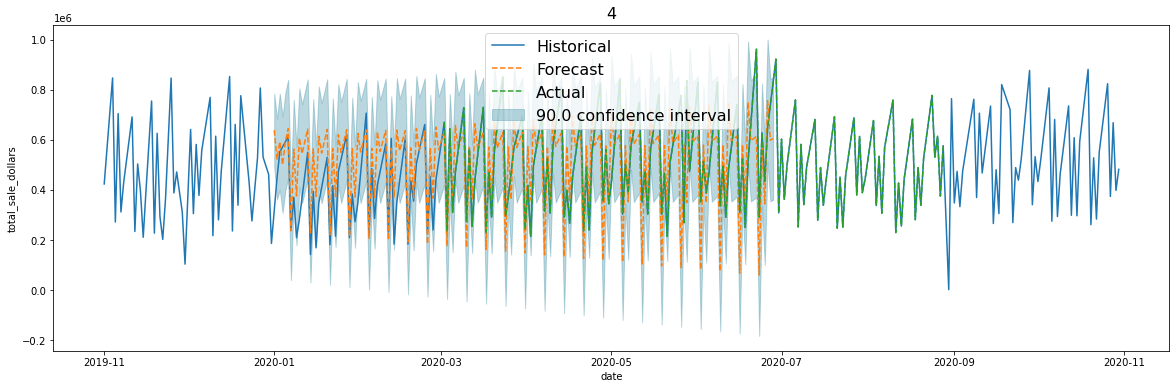

In [102]:
# We are forecasting only upto July 2020

clusterlist = list(dfhistorical.Cluster.unique())

for cluster in clusterlist:
    datah = dfhistorical[dfhistorical.Cluster==cluster].sort_values('date')
    dataf = dfforecast[dfforecast.Cluster==cluster].sort_values(['forecast_timestamp'])
    dataa = dfactual[dfactual.Cluster==cluster].sort_values('date')
    plot_historical_and_forecast(input_timeseries = datah, 
                             timestamp_col_name = "date", 
                             data_col_name = "total_sale_dollars", 
                             forecast_output = dataf, 
                             actual = dataa,
                             title = cluster,
                             plotstartdate = "2019-11-01")

## Create a dashboard with Data Studio

Follow the steps in this section to create an interactive, shareable dashboard of the forecasted data by using Data Studio. 

### Create a view containing the data for the dashboard

Create a view that concatenates the historical and forecasted data. The SQL before the `UNION ALL` clause selects the historical data. The SQL after the `UNION ALL` clause uses `ML.FORECAST` to generate the forecasted value and the prediction interval. The query uses different fields for `history_value` and `forecasted_value` so that you can plot them in different colors in a following step.

In [106]:
%%bigquery --params $ARIMA_PARAMS  --project $PROJECT_ID 

CREATE OR REPLACE VIEW bqmlforecast.outputdata_datastudio AS (
  SELECT
    date AS timestamp,
    cluster,
    SUM(total_sale_dollars) AS history_value,
    NULL AS forecast_value,
    NULL AS prediction_interval_lower_bound,
    NULL AS prediction_interval_upper_bound
  FROM
    bqmlforecast.iowa_liquor_sales_forecasting
    GROUP BY cluster,date
  UNION ALL
  SELECT
    EXTRACT(DATE
    FROM
      forecast_timestamp) AS timestamp,
    cluster,
    NULL AS history_value,
    forecast_value,
    prediction_interval_lower_bound,
    prediction_interval_upper_bound
  FROM
    ML.FORECAST(MODEL bqmlforecast.arima_model,
      STRUCT(305 AS horizon, 0.9 AS confidence_level)) 
  ORDER BY timestamp
  )

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 953.47query/s]  


""


In [109]:
%%bigquery --params $ARIMA_PARAMS  --project $PROJECT_ID 

SELECT * from bqmlforecast.outputdata_datastudio
WHERE history_value>0 AND histo

Query complete after 0.00s: 100%|██████████| 6/6 [00:00<00:00, 3255.60query/s]                        
Downloading: 0rows [00:00, ?rows/s]


,timestamp,cluster,history_value,forecast_value,prediction_interval_lower_bound,prediction_interval_upper_bound


### Export the data to DataStudio

1. In the **Resources** pane of the [BigQuery console](https://console.cloud.google.com/bigquery), navigate to the `bqmlforecast.outputdata_datastudio` view and select it.
1. Click **Export** and then select **Explore with Data Studio**. A new tab opens in the browser.

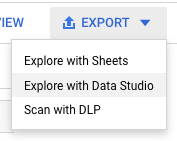


### Set the chart type

In the **Chart** pane, find the **Time series chart** icon and click it, as shown in the following screenshot:

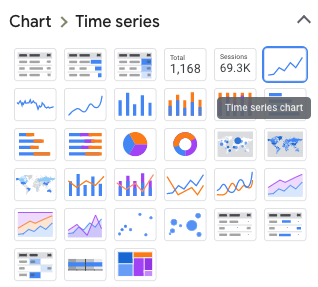

### Set the dashboard data

1. On the **Data** tab, find the **Metric** section.
1. Click **Add metric** to add the `history_value` field.
1. Repeat step 2 to add the `forecast_value`, `prediction_interval_lower_bound` and `prediction_interval_upper_bound` fields.

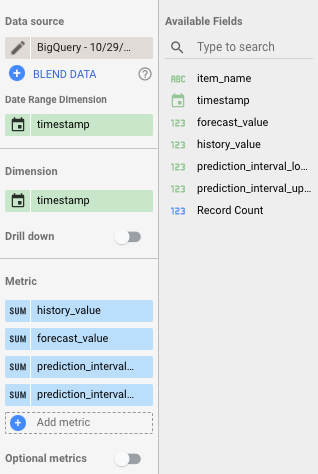

### Set the dashboard style

1. On the **Style** tab, scroll down to the **General** section.
1. For the **Missing Data** option, choose **Linear Interpolation**.

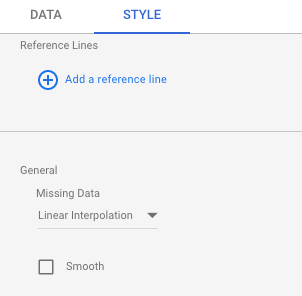

### Set the dashboard filter

1. In the **Filter** pane, click **Drop metric or dimension fields here to create filters** and choose `item_name`.
1. Click `item_name` to see a list of values to filter by.
1. Select **Five O'clock Vodka** to inspect the time series data for just that product.

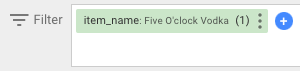

### Review the dashboard

After you complete these steps, the following plot appears in the left panel. The input history time series is in blue, while the forecasted series is in green. The prediction interval is the region between the lower bound series and the upper bound series.

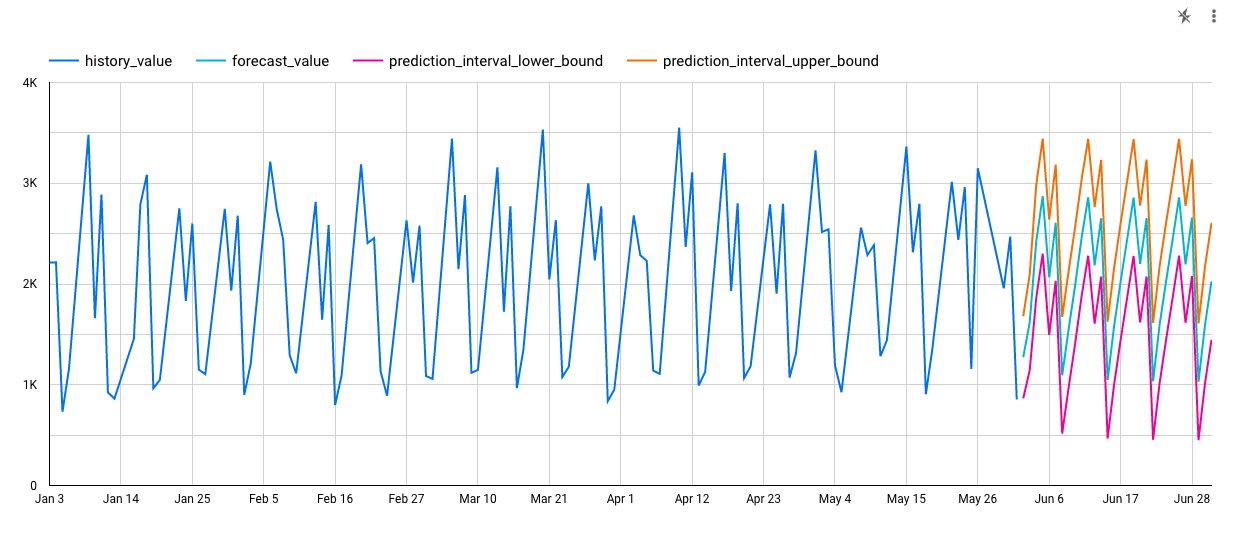